# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [15]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
import math

### Задание 1 (1 балл)
Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [119]:
from collections import Counter

def gini(x):
    c = Counter(x)
    #print(c)
    total = len(x)
    ans = 0
    for v in c.values():
        ans += 1.*v/total*(1-1.*v/total)
    return ans
    
def entropy(x):
    c = Counter(x)
    #print(c)
    total = len(x)
    ans = 0
    for v in c.values():
        ans -= 1.*v/total*(math.log2(1.*v/total))
    return ans

def gain(left_y, right_y, criterion):
    joined = np.concatenate((left_y, right_y))
    return (len(joined) * criterion(joined) - len(left_y) * criterion(left_y) - len(right_y) * criterion(right_y))*1./len(joined)

### Задание 2 (1 балл)
Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__ (например, для вычисления вероятности в следующем задании)

In [120]:
class DecisionTreeLeaf:
    def __init__(self):
        self.y = None
        raise NotImplementedError()

class DecisionTreeNode:
    def __init__(self, depth):
        self.split_dim = None
        self.split_value = None
        self.left = None
        self.right = None
        self.depth = depth
        
        self.leaf = False
        self.elems = None
        self.y = None

### Задание 3 (6 баллов)
Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`. Вероятности классов в листе можно определить через количество объектов соответствующего класса в листе. 

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [157]:
from collections import deque

def get_class(x):
    p = Counter(x)
    return max(p.keys(), key=lambda k: p[k])

def get_probs(x):
    p = Counter(x)
    return {k : v*1./sum(p.values()) for k,v in p.items()}

class DecisionTreeClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1):
        self.root = None
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
    
    def fit(self, X, y):
        root = DecisionTreeNode(0)
        self.root = root
        elems = range(len(y))
        q = deque()
        q.append((root, elems))
        while (q):
            node, elems = q.popleft()
            if node.depth == self.max_depth:
                node.leaf = True
                node.elems = y[elems]
                node.y = get_class(y[elems])
                continue
            
            # iterate over features
            cur_split_dim = -1
            cur_split_value = -1
            cur_gain = 0
            cur_left = []
            cur_right = []
            for i in range(X.shape[1]):
                vals = X[:, i]
                minn = min(vals)
                maxx = max(vals)
                for b in np.random.uniform(minn, maxx, 20):
                    elem_left = []
                    elem_right = []
                    for e in elems:
                        if X[e, i] < b:
                            elem_left.append(e)
                        else:
                            elem_right.append(e)
                    #print(y)
                    #print(elem_left)
                    tmp_gain = gain(y[elem_left], y[elem_right], gini if self.criterion=='gini' else entropy)
                    if tmp_gain > cur_gain:
                        cur_gain = tmp_gain
                        cur_split_dim = i
                        cur_split_value = b
                        cur_left = elem_left.copy()
                        cur_right = elem_right.copy()
                        
            if len(cur_left) < self.min_samples_leaf or len(cur_right) < self.min_samples_leaf: #cur_gain < 0.01 or 
                node.leaf = True
                node.elems = y[elems]
                node.y = get_class(y[elems])
            else:
                left_node = DecisionTreeNode(node.depth+1)
                right_node = DecisionTreeNode(node.depth+1)
                q.append((left_node, cur_left))
                q.append((right_node, cur_right))
                node.split_dim = cur_split_dim
                node.split_value = cur_split_value
                node.left = left_node
                node.right = right_node
        
                
    def predict_proba(self, X):
        ans = []
        for i in range(X.shape[0]):
            node = self.root
            while not node.leaf:
                if X[i, node.split_dim] < node.split_value:
                    node = node.left
                else:
                    node = node.right
            ans.append(get_probs(node.elems))
        return ans
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [158]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if not tree_root.leaf: #isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [159]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if not tree_root.leaf: #isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Задание 4 (2 балла)

Протестируйте решение на данных cancer и spam (датасеты из директории `hw2_data`).
Выполните загрузку и предобработку данных.


Если необходимо, попробуйте разные наборы параметров для получения лучшего результата.

Посчитайте метрики `precision`, `recall`, `accuracy` для модели дерева.
Сравните значения метрик с результатами модели kNN из предыдущего задания (можно использовать реализацию из библиотеки `sklearn`). 

Какой нужен препроцессинг данных для моделей?
Какая модель делает предсказания лучше?  Предположите, почему.

_Ваш ответ_

Для KNN нужно применить шкалирование, чтобы у каждого признака был одинаковый разброс значений и они вносили одинаковый вес при вычислении расстояния между образцами. Для дерева это не нужно, так как здесь для каждого признака тестируются свои значения.

Дерево решений дает более хорошие результаты, так как учитывает разные признаки по отдельности и пытается выбрать наиболее оптимальные для разделения признаки и подобрать их параметры, а не основывается только на расстоянии между образцами.

In [167]:
from sklearn.metrics import accuracy_score, \
                            recall_score, precision_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [168]:
CANCER_DATA_PATH = "hw2_data/cancer.csv"
SPAM_DATA_PATH = "hw2_data/spam.csv"
def read_cancer_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    df = pd.read_csv(path_to_csv, header=0)
    y = [1 if i == 'M' else 0 for i in df["label"]]
    return df.drop("label", axis=1).to_numpy(), np.array(y)

def read_spam_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    df = pd.read_csv(path_to_csv, header=0)
    y = df["label"]
    return df.drop("label", axis=1).to_numpy(), np.array(y.values)

X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)
X_spam, y_spam = read_spam_dataset(SPAM_DATA_PATH)

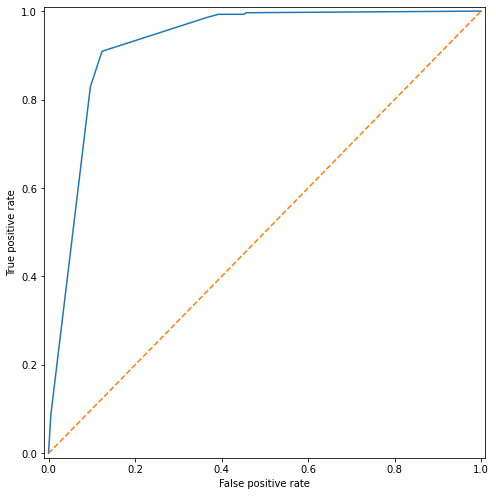

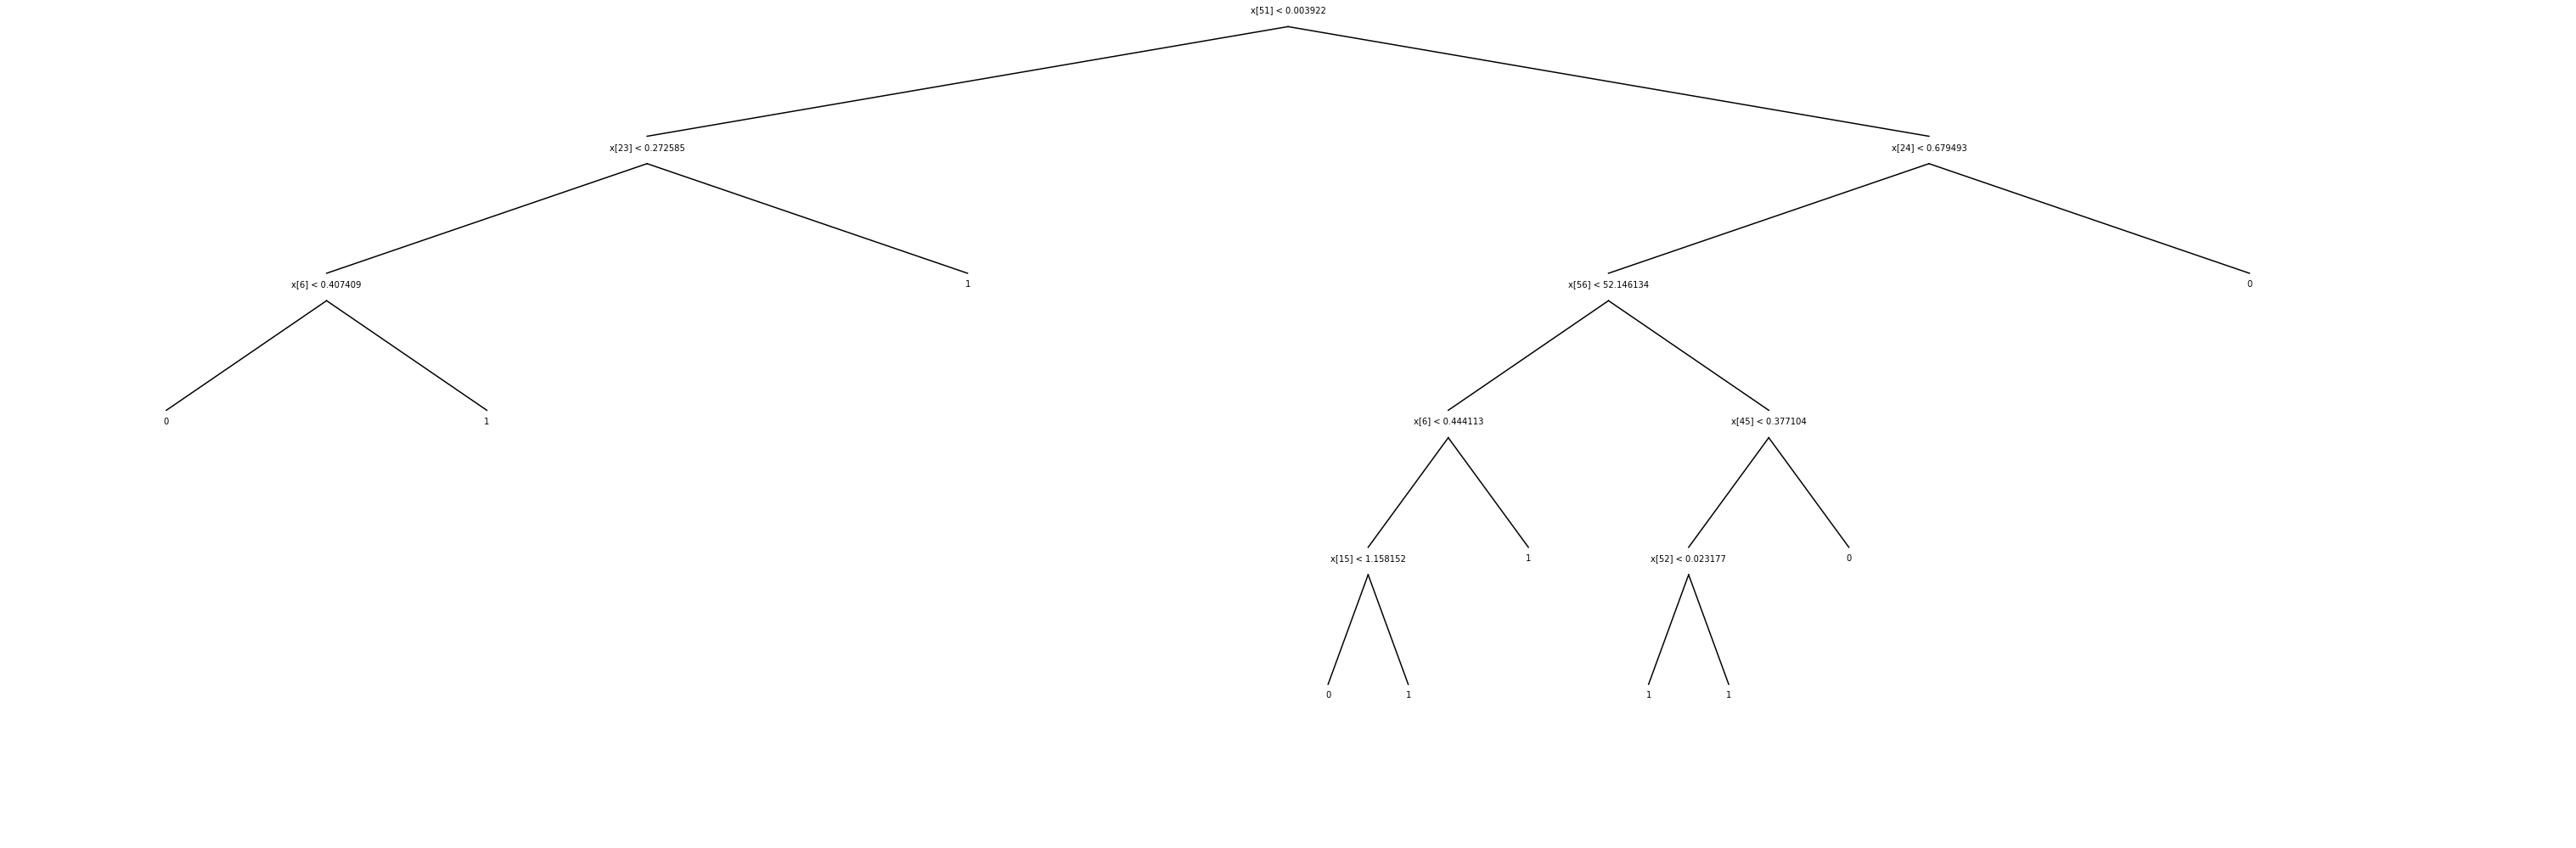

Precision=0.8670212765957447; recall=0.8763440860215054; accuracy=0.89587852494577


In [177]:
X_train, X_test, y_train, y_test = train_test_split(X_spam, y_spam, train_size = 0.9)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X_train, y_train)
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)
y_pred = tree.predict(X_test)
print(f'Precision={precision_score(y_test, y_pred)}; recall={recall_score(y_test, y_pred)}; accuracy={accuracy_score(y_test, y_pred)}')

In [187]:
X_train, X_test, y_train, y_test = train_test_split(MinMaxScaler().fit_transform(X_spam), y_spam, train_size = 0.9)
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f'Precision={precision_score(y_test, y_pred)}; recall={recall_score(y_test, y_pred)}; accuracy={accuracy_score(y_test, y_pred)}')

Precision=0.8650306748466258; recall=0.8197674418604651; accuracy=0.8850325379609545


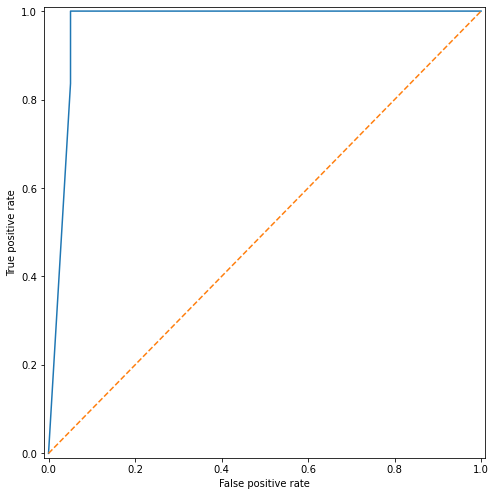

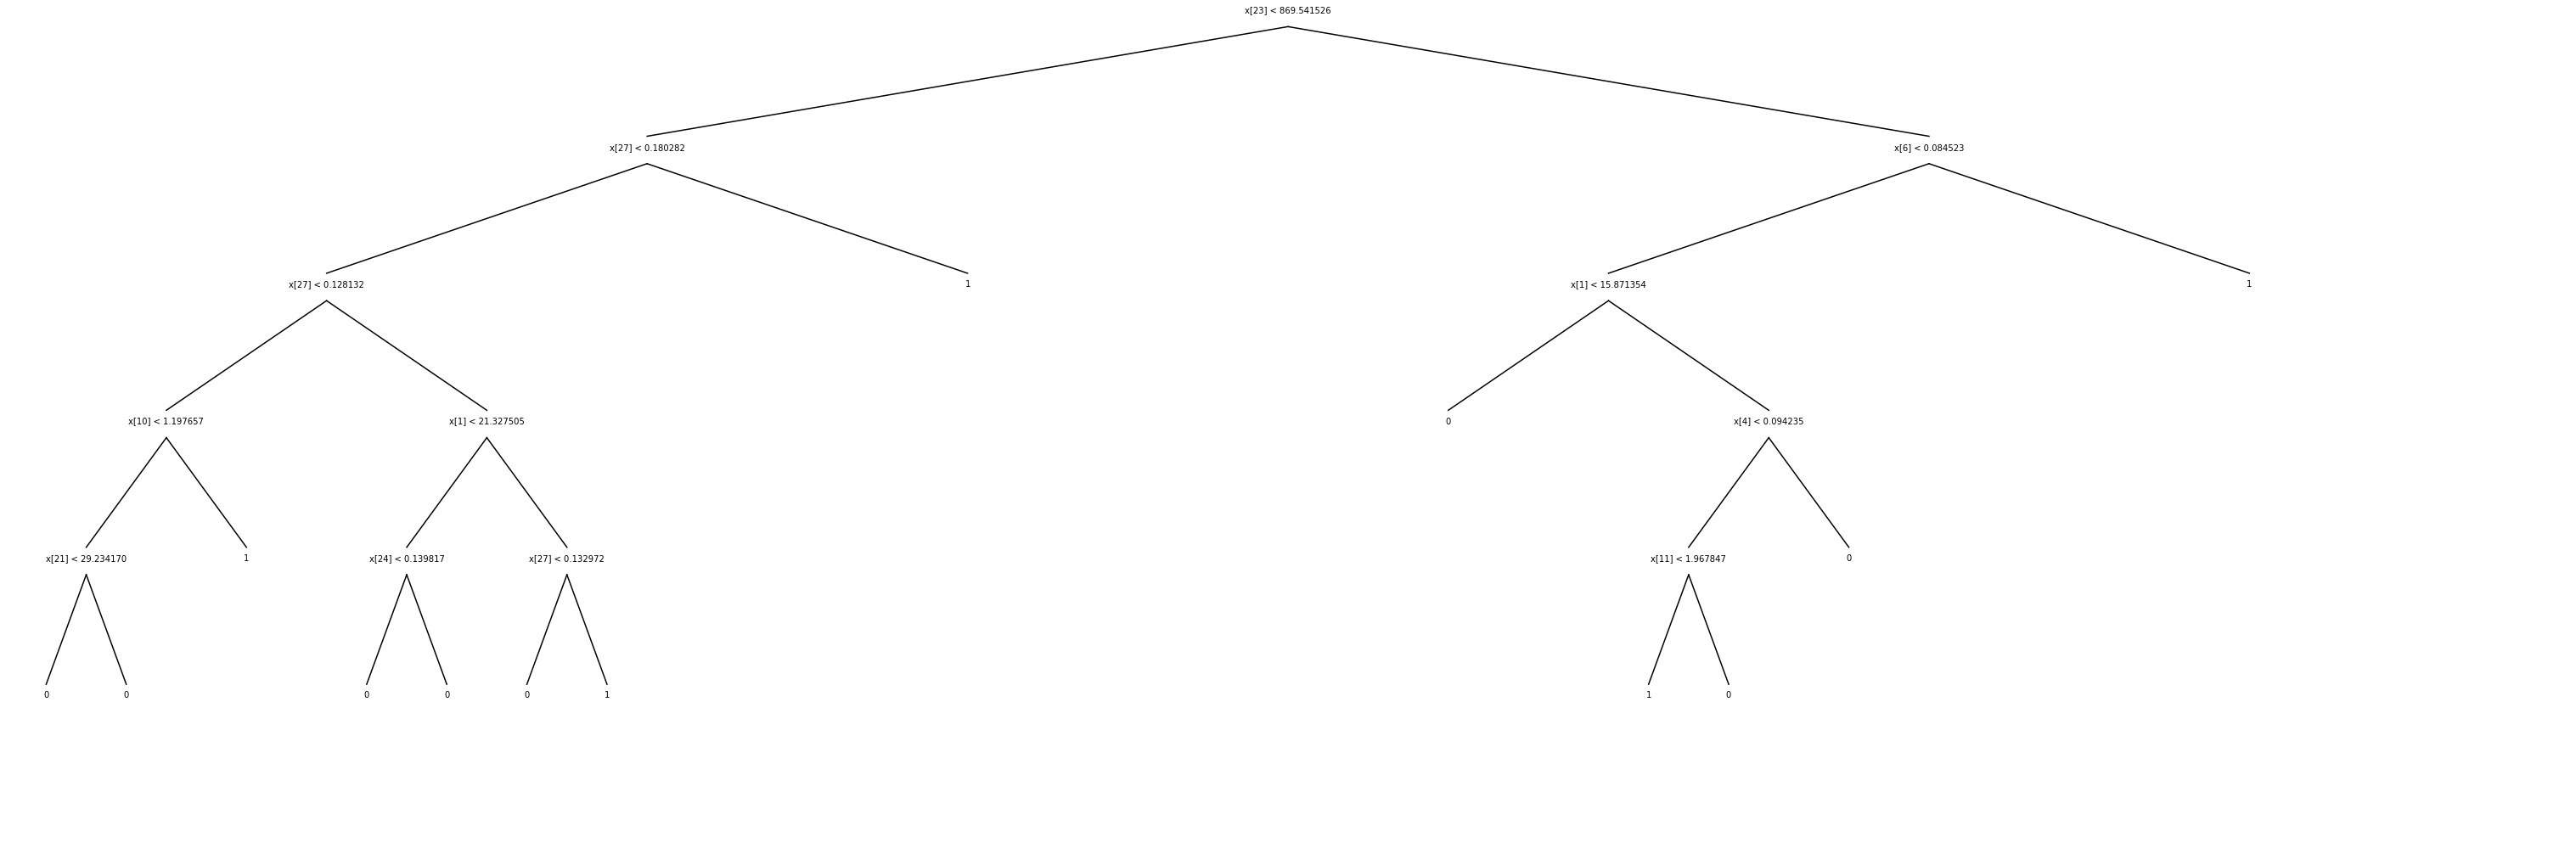

Precision=1.0; recall=0.9491525423728814; accuracy=0.9736842105263158


In [192]:
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, train_size = 0.8)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=1)
tree.fit(X_train, y_train)
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)
y_pred = tree.predict(X_test)
print(f'Precision={precision_score(y_test, y_pred)}; recall={recall_score(y_test, y_pred)}; accuracy={accuracy_score(y_test, y_pred)}')

In [202]:
X_train, X_test, y_train, y_test = train_test_split(MinMaxScaler().fit_transform(X_cancer), y_cancer, train_size = 0.8)
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f'Precision={precision_score(y_test, y_pred)}; recall={recall_score(y_test, y_pred)}; accuracy={accuracy_score(y_test, y_pred)}')

Precision=0.9142857142857143; recall=0.9411764705882353; accuracy=0.956140350877193
